# ML4SETI Code Challenge 2nd Place Model

This notebook shows you how to run the winning model from the [ML4SETI code challenge](https://github.com/setiquest/ml4seti); a public code challenge issued by IBM and the SETI Insititute in the summer of 2017. The challenge was to build the best signal classification model from a set of simulated (and labeled) radio-telescope data files. These time-series simulated measurements, much like the real data acquired by the SETI Institute during observations at the Allen Telescope Array, were converted to spectrograms, represented as 2D images, and used to train various machine-learning models. 

The [2nd place team](https://compete.cognitiveclass.ai/event/5957f1ec13880a001fd89bd7/leaderboard), [Signet (aka Sagelywizard)](https://github.com/sagelywizard/ml4seti), achieved a classification accuracy of 94.6% with a moel based on a [Densely Connected Convolutional Network](https://arxiv.org/pdf/1608.06993.pdf). 

The code below will install the necessary Python packages, Signet's model, and demonstrate how to use that model to classify a simulated data file from one of the test sets. 

**Note that you should be running Python 3.5. Go to the menu above to change: Kernel -> Change Kernel**

In [ ]:
# Uncomment below and run once to install necessary packages

# !pip install --upgrade http://download.pytorch.org/whl/cu75/torch-0.2.0.post3-cp35-cp35m-manylinux1_x86_64.whl 
# !pip install torchvision
# !pip install tabulate
# !pip install --upgrade scikit-learn
# !pip install --upgrade numpy
# !pip install --upgrade ibmseti==2.0.0.dev5
# !pip install --upgrade pandas

In [ ]:
# Uncomment and run once to install SETI preview test set

# !wget https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_v3_zipped/primary_testset_preview_v3.zip
# !unzip -q primary_testset_preview_v3.zip

<br>
## Model stored in IBM Object Storage

The parameters for our models have been placed in an [IBM Cloud Object Storage](https://console.bluemix.net/docs/services/ObjectStorage/os_works_public.html) service instance. The Access Control Lists for the containers in Object Storage have been set such that the objects in those containers are publicly available. 

In [ ]:
# Uncomment and run once to download Signet final model parameters

# import requests
# import shutil

# model_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/code_challenge_models/signet/final_densenet_model.pth'
# r = requests.get(model_url, stream=True)
# filename = 'signet_final_densenet_model.pth'
# with open(filename, 'wb') as fout:
#     shutil.copyfileobj(r.raw, fout)
# print('saved {}'.format(filename))

In [1]:
!ls -alrth

total 2.6G
drwxr-xr-x  2 s8c9-b67323f4e929fb-1cef86459d43 users 160K Jun 28 19:11 primary_testset_preview_v3
-rw-------  1 s8c9-b67323f4e929fb-1cef86459d43 users 666M Jul  1 16:51 primary_testset_preview_v3.zip
-rw-------  1 s8c9-b67323f4e929fb-1cef86459d43 users 209M Sep  7 15:33 signet_final_densenet_model.pth
drwxr-xr-x  3 s8c9-b67323f4e929fb-1cef86459d43 users 4.0K Sep  7 15:33 .
drwxr-xr-x 11 s8c9-b67323f4e929fb-1cef86459d43 users 4.0K Sep 15 20:35 ..


## Restart your kernel

After you've `pip install`ed the packages above, you'll need to restart your kernel. 

1. Comment out the code in the cells above *(within a cell you drag and select the lines of code then press Command+'/', or Ctrl+'/', to comment and uncomment entire blocks of code)*
2. In the menu above select Kernel -> Restart.
3. Run the cells below


<br>
## Define the Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import OrderedDict

class DenseNet(nn.Module):
    def __init__(self, pretrained):
        super(DenseNet, self).__init__()
        self.densenet = list(torchvision.models.densenet201(
            pretrained=pretrained
        ).features.named_children())
        self.densenet[0] = ('conv0', nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False))
        self.densenet = nn.Sequential(OrderedDict(self.densenet))
        self.linear = nn.Linear(3840, 7)

    def forward(self, minibatch):
        dense = self.densenet(minibatch)
        out = F.relu(dense, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7).view(dense.size(0), -1)
        return self.linear(out)

In [3]:
import sys

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import ibmseti  #need version 2.0.0 or greater (lastest version: pip install ibmseti==2.0.0.dev5)
import time

def get_spectrogram(filename):
    raw_file = open(filename, 'rb')
    aca = ibmseti.compamp.SimCompamp(raw_file.read())
    tensor = torch.from_numpy(aca.get_spectrogram()).float().view(1, 1, 384, 512)
    return Variable(tensor, volatile=True)

def get_densenet(model_path):
    dense = DenseNet(False).cpu()
    dense.eval()
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    dense.load_state_dict(state['model'])
    return dense
    

<br>
## Load the model with trained parameters

In [4]:
%time model = get_densenet('signet_final_densenet_model.pth')

CPU times: user 300 ms, sys: 174 ms, total: 475 ms
Wall time: 2.15 s


<br>
## Select a simulation data file and get the spectrogram

In [5]:
simfile = 'primary_testset_preview_v3/00b3b8fdb14ce41f341dbe251f476093.dat'

In [6]:
%time spec = get_spectrogram(simfile)

CPU times: user 11.6 ms, sys: 1.22 ms, total: 12.8 ms
Wall time: 101 ms


<br>
## Apply the model to calculate class probabilities

In [7]:
%time results = F.softmax(model(spec)).data.view(7)

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 1.17 s


In [8]:
import numpy as np
probs = np.array(results.tolist())

In [9]:
print('final class probabilities')
print(probs)

class_list = ['brightpixel', 'narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']
print('signal classification')
predicted_signal_class = class_list[probs.argmax()]
print(predicted_signal_class)

final class probabilities
[  3.57749320e-15   3.64963370e-07   6.03338299e-12   2.05171563e-18
   9.99325335e-01   3.58738261e-10   6.74286275e-04]
signal classification
squarepulsednarrowband


<br>
## Confirm prediction

We will display the signal as a spectrogram to confirm the predicted class. Addtionally, the signal classes for the preview test set from the code challenge are available in the Github repository, allowing you to explicitely check the prediction against the actual signal class. (The classes for the final test set are not published so that teams may [submit a scorecard](https://github.com/setiQuest/ML4SETI/blob/master/Judging_Criteria.ipynb) to the [final test set scoreboard](https://compete.cognitiveclass.ai/event/5957f1ec13880a001fd89bd7) even though the code challenge has officially ended.)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

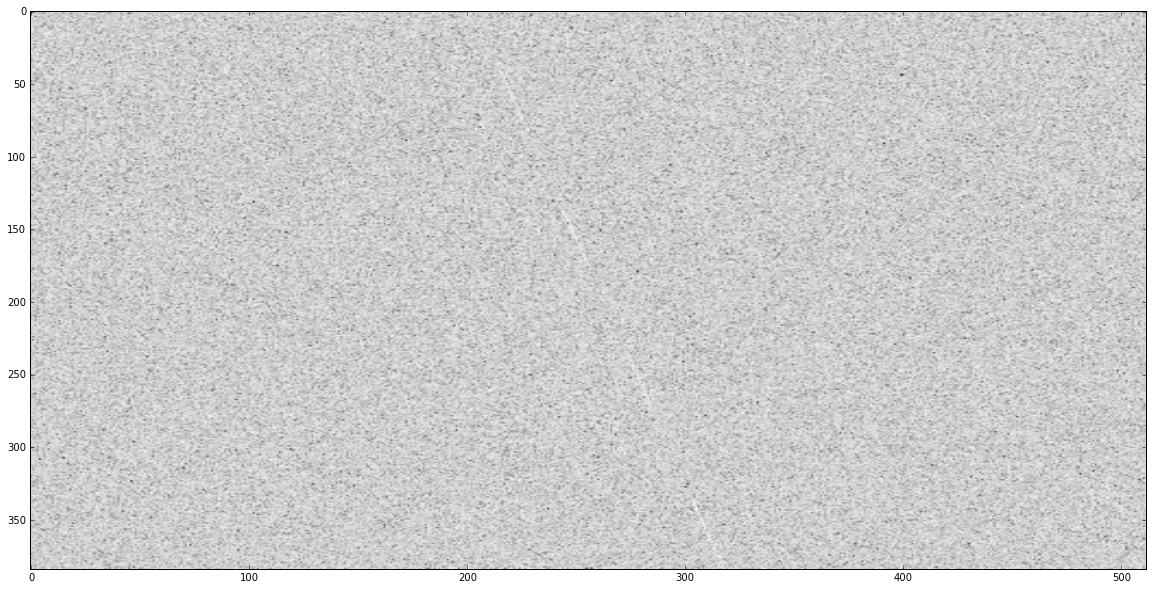

In [11]:
aca = ibmseti.compamp.SimCompamp(open(simfile,'rb').read())
spectrogram = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0], cmap='gray')

<br>
## Check the test set class from the published list of signal classes.

In [12]:
import pandas as pd
preview_test_set_pd = pd.read_csv('https://github.com/setiQuest/ML4SETI/raw/master/results/private_list_primary_v3_testset_preview_uuid_class_29june_2017.csv', index_col=None)

In [13]:
expected_signal_class = preview_test_set_pd[preview_test_set_pd.UUID == simfile.split('/')[-1].rstrip('.dat')].SIGNAL_CLASSIFICATION.values[0]

In [14]:
assert predicted_signal_class == expected_signal_class
print(expected_signal_class)

squarepulsednarrowband
